In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib qt

In [4]:
import matplotlib.pyplot as plt

In [5]:
import importlib

In [6]:
import itertools

In [7]:
import math

In [8]:
import numpy as np

In [9]:
import os

In [10]:
import pickle

In [11]:
import pprint

In [20]:
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

In [12]:
import genesets

---

## Breakdown of experimental evidence codes

**2015 November 17**

In [4]:
os.chdir(os.path.join('..', '..', 'DataDownload', 'BIOGRID', 'BIOGRID-ORGANISM-3.4.130.tab2'))

In [9]:
def experimental_evidence_breakdown(filename, colNum):
    """INPUT:
    1.) <string> name of BIOGRID file to read
    2.) <integer> number of 1st interactor column to read
    """
    typeCounts = dict()
    genes = set()
    for line in open(filename):
        tokens = line.split('\t')
        if tokens[12] == 'genetic':
            genes.update(tokens[colNum:colNum+2])
            typeCounts[tokens[11]] = typeCounts.get(tokens[11], 0) + 1
    print('Number of genes:', len(genes))
    print('Experimental evidence code breakdown:')
    pprint.pprint(typeCounts)

In [6]:
biogridFile = 'BIOGRID-ORGANISM-Schizosaccharomyces_pombe_972h-3.4.130.tab2.txt'

In [7]:
sysNameCol = 5  # systematic name

In [11]:
experimental_evidence_breakdown(biogridFile, sysNameCol)

Number of genes: 3196
Experimental evidence code breakdown:
{'Dosage Growth Defect': 49,
 'Dosage Lethality': 82,
 'Dosage Rescue': 850,
 'Negative Genetic': 35391,
 'Phenotypic Enhancement': 1147,
 'Phenotypic Suppression': 1052,
 'Positive Genetic': 15351,
 'Synthetic Growth Defect': 1978,
 'Synthetic Lethality': 948,
 'Synthetic Rescue': 880}


---

**2015 November 17**

There is no functional gene network for *S. pombe.*

The protein complex file *Sp_prot_cmplx_Ryan2013.txt* contains 2 columns with the 1<sup>st</sup> column containing genes and the 2<sup>nd</sup> containing the protein complex names. Therefore, to process this file, simply delete the header line and switch the columns. 

In [2]:
%%bash
cd /work/jyoung/DataDownload/
sed '1d' Sp_prot_cmplx_Ryan2013.txt > ../DataProcessed/Sp_prot_cmplx_Ryan2013.tmp
cd ../DataProcessed/
awk -F $'\t' '{t = $1; $1 = $2; $2 = t; print;}' OFS=$'\t' Sp_prot_cmplx_Ryan2013.tmp > Sp_prot_cmplx_Ryan2013.2col.txt
rm Sp_prot_cmplx_Ryan2013.tmp

At the moment, *get_all_genes()* in *geneintactmatrix.py* has hard-coded the BIOGRID columns to read. As the protein complex file *Sp_prot_cmplx_Ryan2013.txt* uses the systematic gene name, i.e. SPBC17D11.05, BIOGRID columns 5-6 are hard-coded in to the *get_all_genes()* function. 

**2015 November 18**

A test run of *clustintactparallel.py* for <font color='red'>negative genetic</font> interactions started @ 02:49.

**2015 November 19-20, 22-23**

Job finished @ 02:36; output written as *tmp/pombe_1st_run.p*. Examining the results:

In [13]:
os.chdir(os.path.join('..', 'tmp'))

In [14]:
output = pickle.load(open('pombe_1st_run.p', 'rb'))

In [15]:
pairpvals = list(itertools.chain.from_iterable(output))
pairpvals.sort(key=lambda f: f[1])

In [8]:
pairpvals[:5]

[(('NuRD complex', 'Rpd3S complex'), 0.00019998000199980003),
 (('NuRD complex', 'NuA4 histone acetyltransferase complex'),
  0.00019998000199980003),
 (('RSC complex', 'Swr1 complex'), 0.00029997000299970003),
 (('NuRD complex',
   'eukaryotic translation initiation factor 3 complex, eIF3e'),
  0.0005999400059994001),
 (('NuRD complex', 'eukaryotic 43S preinitiation complex'),
  0.0006999300069993001)]

There are a total of 5356 = ${104 \choose 2}$ entries. It is clear, unfortunately, that there will be no statistical significance under Benjamini-Hochberg. 

What does the distribution of p-values look like?

In [22]:
numBins = math.sqrt(len(pairpvals))

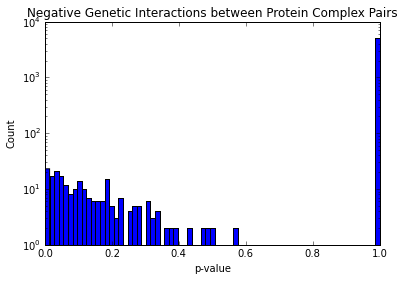

In [25]:
n, bins, patches = plt.hist(np.array([t[1] for t in pairpvals]), bins=numBins, log=True)
plt.xlabel('p-value')
plt.ylabel('Count')
plt.title('Negative Genetic Interactions between Protein Complex Pairs')
plt.show()

Create a plotting function that accepts protein complex pair names, and plots the interactions between them as a network, all in a single figure. Refer to the script *clustintactvis.py*. 

Also, what is the distribution of overlap between protein complex pairs?

In [41]:
protcmplxfile = os.path.join('..', '..', 'DataProcessed', 'Sp_prot_cmplx_Ryan2013.2col.txt')
cmplx2genes = genesets.process_file(protcmplxfile)

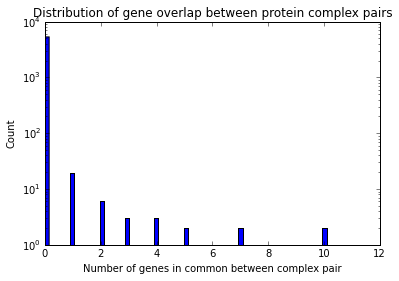

In [12]:
pairIntersect = [len(set(cmplx2genes[pair[0]]) & set(cmplx2genes[pair[1]])) 
                 for pair in itertools.combinations(cmplx2genes.keys(), 2)]

numBins = math.sqrt(len(pairIntersect))
n, bins, patches = plt.hist(pairIntersect, bins=numBins, log=True)
plt.xlabel('Number of genes in common between complex pair')
plt.ylabel('Count')
plt.title('Distribution of gene overlap between protein complex pairs')
plt.show()

Examine the top-scoring/most significant complex pair interaction by visualizing it as a network:

In [13]:
os.chdir(os.path.join('..', 'src'))

In [37]:
import geneintactmatrix

In [38]:
adjMat, gene2idx = geneintactmatrix.make_adj('pombe', 'Negative Genetic')

In [39]:
import clustintactvis

In [21]:
vispairs = [pairpvals[i][0] for i in range(10)]

In [26]:
clustintactvis.btw_complex_net(vispairs, cmplx2genes, gene2idx, adjMat)

/work/anaconda3/lib/python3.4/site-packages/matplotlib/backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


**2015 November 23**

Renamed and moved pickled result from the parallel run on negative genetic:

    mkdir pombeIntactClust
    mv tmp/pombe_1st_run.p results/pombeIntactClust/NegGenetBtwProtRandNet.p

**2015 November 21, 23**

Revisit the binomial model for assessing cluster interaction significance; modify *clust_intact.py* accordingly. See how it works on negative genetic interactions. 

In [27]:
%run clust_intact.py


Choose from the following organisms (enter species name):
1) cerevisiae
2) pombe
3) melanogaster
4) sapiens
pombe

Use "functional net" or "protein complexes" for clusters?
protein complexes
Enter type of genetic interaction:
Negative Genetic


In [30]:
resultsSorted = sorted(results, key=lambda f: f[1])

In [31]:
pvals = [t[1] for t in resultsSorted]

In [34]:
rejected, pvalsCor = fdrcorrection0(pvals, is_sorted=True)

In [35]:
np.sum(rejected)

3

In [36]:
os.getcwd()

'/work/jyoung/genetic_interact/src'

In [42]:
clustintactvis.btw_complex_net([t[0] for t in resultsSorted[:3]], cmplx2genes, gene2idx, adjMat)

/work/anaconda3/lib/python3.4/site-packages/matplotlib/backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)
